In [5]:
%matplotlib inline
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import emcee
import corner as triangle
from gatspy.periodic import LombScargle

In [6]:
def linear_model(period,transit_num,intercept):
        
    m = period
    x = transit_num
    b = intercept
    
    y = m*x + b
    return y #mid-transit times

In [7]:
def lnprior(theta):
    
    period, intercept = theta
        
    if (planet_period-1 <= period <= planet_period+1) or (planet_epoch-0.5 <= intercept <= planet_epoch+0.5):
        return 0.0
    return -np.inf

In [8]:
def lnprob(theta):
        
    # Pull out some model parameters
    period, intercept = theta     
    
    # First we want a model to perform the lnprob calculation with.
    model = linear_model(period,transit_num,intercept)
        
    # We need to make sure the uniform priors are accounted for:
    ln_prior = lnprior(theta)
    
    # This is a Gaussian likelihood, for independent data points
    
    chisq = np.sum((t0 - model)**2/(t0_err)**2)
    ln_like = (np.sum(1/np.sqrt(2*np.pi*(t0_err))) - 0.5*chisq)
    
    return ln_prior+ln_like

In [9]:
def corner(samples):
    
    labels = ['Period (d)','Epoch_0 (BJD_TDB)']
    Samples = samples.T
    
    np.random.seed(40)
    figure = triangle.corner(Samples,labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
    plt.savefig('TOI_{:.0f}_PeriodCorner.pdf'.format(toi))

In [95]:
# def periodogram(best_params):
#     best_period = best_params[0]
#     model = LombScargle().fit(transit_num*best_period, residual*t0_err, t0_err)
#     periods, power = model.periodogram_auto(nyquist_factor=1000)

#     fig, ax = plt.subplots()
#     ax.plot(periods, power)
#     ax.set(xlim=(0,30),
#            xlabel='period (days)',
#            ylabel='Lomb-Scargle Power')

In [10]:
def plotline(samples,best_params):
    
    labels = ['Period (d)','Epoch_0 (BJD_TDB)']
    Samples = samples.T
    
    hires_times = np.linspace(0,80,1000)
    period_best,epoch_best = best_params
    burnin = int(0.25*nsteps)
    
    Period,Intercept = samples
    
    model_to_plot = linear_model(period_best,hires_times,epoch_best)
    
    best_model = linear_model(period_best,transit_num,epoch_best)
    residual = (t0-best_model)/t0_err
    
    #########################
    # Plot the best-fit model
    #########################
            
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                               figsize=(10,7),sharex=True)
    
    a0.set_title('Period Fitting'.format(toi),fontsize=20)
    a0.errorbar(transit_num,t0,yerr=t0_err,
                fmt='o',alpha=0.5,color='royalblue',markersize='5',
                label='Observed Mid-Transit Times')
    a0.plot(hires_times,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
    a0.set_ylabel('Epoch (BJD-2457000)',fontsize=18)
    a0.legend(loc='lower right')
    
    for j in range(0,200,1):
        i = np.random.randint(low=0,high=(nsteps-burnin)*nwalkers)
        sigma_model = linear_model(period_sam[i],hires_times,intercept_sam[i])
        a0.plot(hires_times,sigma_model,color='red',alpha = 0.1,
                linewidth=0.8,zorder=-1000,label='Random Samples')
        
    ####################
    # Plot the residuals
    ####################

    a1.scatter(transit_num,residual,color='royalblue',alpha=0.5)
    a1.axhline(0,color='k')
    a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
    a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
    a1.set_xlabel('Transit Number')
    
    plt.savefig('TOI_{:.0f}_Period_fit.pdf'.format(toi))

In [35]:
data = ascii.read('toi_122_ephem.txt')
toi = 122.01
planet_period = 5.077972
planet_epoch = 1329.1215

In [21]:
data = ascii.read('toi_237_ephem.txt')
toi = 237.01
planet_period = 5.436086
planet_epoch = 1355.249810

In [38]:
transit_num = data['num'] #'x'
t0 = data['t0'] #'y'
t0_err = data['t0_err']

In [23]:
# intialize some walkers
ndim, nwalkers, nsteps = 2, 100, 5000
burnin = int(0.2*nsteps)

# these are initial parameters
period_init = np.random.uniform(planet_period-0.0001, planet_period+0.0001, nwalkers)
intercept_init = np.random.uniform(planet_epoch-0.003,planet_epoch+0.003, nwalkers)

p0 = np.transpose([period_init,intercept_init])

theta = [planet_period,planet_epoch]

In [24]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
result = sampler.run_mcmc(p0, nsteps)

In [25]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
period_sam, intercept_sam = samples

sig1_P = np.percentile(period_sam, [16., 50., 84.])
sig1_I = np.percentile(intercept_sam, [16., 50., 84.])
best_params = np.array([sig1_P[1],sig1_I[1]])

In [26]:
print('Period = {:.8f}'.format(sig1_P[1]),
      '+ {:.8f}'.format(sig1_P[2]-sig1_P[1]),
      '- {:.8f}'.format(sig1_P[1]-sig1_P[0]))

Period = 5.43609911 + 0.00003886 - 0.00003853


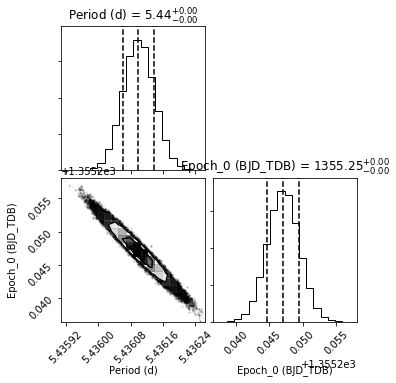

In [27]:
corner(samples)

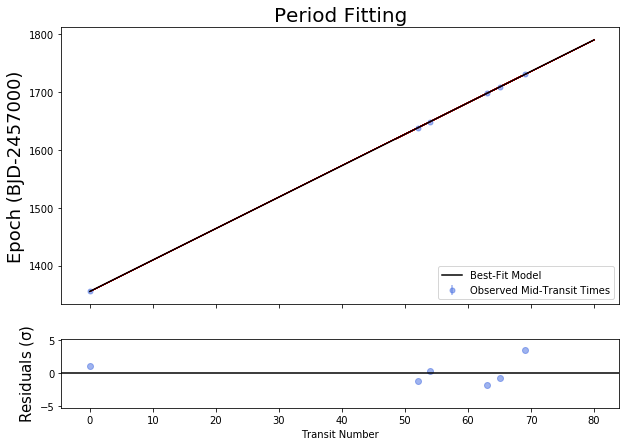

In [28]:
plotline(samples,best_params)

In [30]:
# best_model = linear_model(best_params[0],transit_num,best_params[1])
# residual = (t0-best_model)
# model = LombScargle().fit(transit_num*best_params[0], residual, t0_err)
# periods, power = model.periodogram_auto(nyquist_factor=30)

# fig, ax = plt.subplots()
# ax.plot(periods, power)
# ax.set(xlim=(0,15),
#         xlabel='period (days)',
#         ylabel='Lomb-Scargle Power')

In [34]:
chisq = np.sum((residual/t0_err)**2)/4
print(chisq)

2.301347538708736
